In [19]:
import time, gc, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, backend as K

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [20]:
# Same dataset & encoding style your friend used (multi-hot / bag-of-words)
from tensorflow.keras.datasets import imdb

VOCAB = 10_000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCAB)

def multi_hot_encode(sequences, vocab_size=VOCAB):
    X = np.zeros((len(sequences), vocab_size), dtype="float32")
    for i, seq in enumerate(sequences):
        for t in seq:
            if t < vocab_size:
                X[i, t] = 1.0
    return X

X_train_encoded = multi_hot_encode(X_train, VOCAB)
X_test_encoded  = multi_hot_encode(X_test,  VOCAB)

# Stratified train/val split (fairer than slicing)
X_train_partial, X_val, Y_train_partial, Y_val = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

print("Train:", X_train_partial.shape, "Val:", X_val.shape, "Test:", X_test_encoded.shape)


Train: (20000, 10000) Val: (5000, 10000) Test: (25000, 10000)


In [21]:
def build_model(hidden_layers=2, units=32, activation='relu',
                loss='binary_crossentropy', dropout=0.0, l2_reg=0.0,
                input_dim=VOCAB):
    """
    IMDB sentiment classifier (bag-of-words).
    Covers all knobs required by the assignment.
    """
    reg = regularizers.l2(l2_reg) if l2_reg > 0 else None
    inputs = keras.Input(shape=(input_dim,), name="bow_input")
    x = inputs
    for _ in range(hidden_layers):
        x = layers.Dense(units, activation=activation, kernel_regularizer=reg)(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs, name=f"H{hidden_layers}_U{units}_{activation}_{loss}_do{dropout}_l2{l2_reg}")
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model


In [22]:
# You can shrink this grid if you need speed (e.g., units=[32] first, then expand).
hidden_layers_list = [1, 2, 3]
units_list         = [16, 32, 64]
activations        = ['relu', 'tanh']
losses             = ['binary_crossentropy', 'mse']

# Regularization strategies:
REGS = [
    {'dropout': 0.0, 'l2': 0.0},   # none
    {'dropout': 0.3, 'l2': 0.0},   # dropout (lighter/faster than 0.5)
    # {'dropout': 0.0, 'l2': 1e-4},  # <-- uncomment to include L2 runs too
]

MAX_EPOCHS = 20
BATCH_SIZE = 512
PATIENCE   = 3  # early stopping


In [23]:
results = []

def train_one(hl, units, act, loss, do, l2):
    name = f"HL{hl}_U{units}_{act}_{loss}_do{do}_l2{l2}"
    print(f"\n▶ Training: {name}")
    model = build_model(hl, units, act, loss, do, l2)
    es = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=PATIENCE, mode='max', restore_best_weights=True
    )
    hist = model.fit(
        X_train_partial, Y_train_partial,
        validation_data=(X_val, Y_val),
        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es]
    )
    v_loss, v_acc = model.evaluate(X_val, Y_val, verbose=0)
    t_loss, t_acc = model.evaluate(X_test_encoded, y_test, verbose=0)
    row = dict(name=name, hidden_layers=hl, units=units, activation=act, loss=loss,
               dropout=do, l2=l2, val_acc=float(v_acc), val_loss=float(v_loss),
               test_acc=float(t_acc), test_loss=float(t_loss))
    # cleanup
    K.clear_session(); del model, hist; gc.collect()
    return row

for hl in hidden_layers_list:
    for units in units_list:
        for act in activations:
            for loss in losses:
                for rg in REGS:
                    results.append(train_one(hl, units, act, loss, rg['dropout'], rg['l2']))

df = pd.DataFrame(results).sort_values(['val_acc','test_acc'], ascending=False).reset_index(drop=True)
print("\nTotal runs:", len(df))
df.head(10)



▶ Training: HL1_U16_relu_binary_crossentropy_do0.0_l20.0

▶ Training: HL1_U16_relu_binary_crossentropy_do0.3_l20.0

▶ Training: HL1_U16_relu_mse_do0.0_l20.0

▶ Training: HL1_U16_relu_mse_do0.3_l20.0

▶ Training: HL1_U16_tanh_binary_crossentropy_do0.0_l20.0

▶ Training: HL1_U16_tanh_binary_crossentropy_do0.3_l20.0

▶ Training: HL1_U16_tanh_mse_do0.0_l20.0

▶ Training: HL1_U16_tanh_mse_do0.3_l20.0

▶ Training: HL1_U32_relu_binary_crossentropy_do0.0_l20.0

▶ Training: HL1_U32_relu_binary_crossentropy_do0.3_l20.0

▶ Training: HL1_U32_relu_mse_do0.0_l20.0

▶ Training: HL1_U32_relu_mse_do0.3_l20.0

▶ Training: HL1_U32_tanh_binary_crossentropy_do0.0_l20.0

▶ Training: HL1_U32_tanh_binary_crossentropy_do0.3_l20.0

▶ Training: HL1_U32_tanh_mse_do0.0_l20.0

▶ Training: HL1_U32_tanh_mse_do0.3_l20.0

▶ Training: HL1_U64_relu_binary_crossentropy_do0.0_l20.0

▶ Training: HL1_U64_relu_binary_crossentropy_do0.3_l20.0

▶ Training: HL1_U64_relu_mse_do0.0_l20.0

▶ Training: HL1_U64_relu_mse_do0.3_l20.0


,name,hidden_layers,units,activation,loss,dropout,l2,val_acc,val_loss,test_acc,test_loss
0,HL1_U32_relu_mse_do0.3_l20.0,1,32,relu,mse,0.3,0.0,0.8910,0.083804,0.88784,0.086195
1,HL3_U16_relu_binary_crossentropy_do0.3_l20.0,3,16,relu,binary_crossentropy,0.3,0.0,0.8908,0.282990,0.88644,0.292637
2,HL1_U16_tanh_mse_do0.3_l20.0,1,16,tanh,mse,0.3,0.0,0.8906,0.083913,0.88636,0.086713
3,HL2_U32_relu_mse_do0.3_l20.0,2,32,relu,mse,0.3,0.0,0.8906,0.083667,0.88536,0.086035
4,HL1_U16_relu_binary_crossentropy_do0.3_l20.0,1,16,relu,binary_crossentropy,0.3,0.0,0.8902,0.281220,0.88760,0.285530
5,HL1_U32_relu_binary_crossentropy_do0.3_l20.0,1,32,relu,binary_crossentropy,0.3,0.0,0.8902,0.280188,0.88748,0.286651
6,HL2_U64_relu_binary_crossentropy_do0.3_l20.0,2,64,relu,binary_crossentropy,0.3,0.0,0.8900,0.278384,0.88680,0.280554
7,HL1_U32_tanh_binary_crossentropy_do0.3_l20.0,1,32,tanh,binary_crossentropy,0.3,0.0,0.8898,0.276953,0.88712,0.283236
8,HL2_U16_relu_binary_crossentropy_do0.3_l20.0,2,16,relu,binary_crossentropy,0.3,0.0,0.8898,0.276737,0.88696,0.279614
9,HL2_U16_tanh_binary_crossentropy_do0.3_l20.0,2,16,tanh,binary_crossentropy,0.3,0.0,0.8898,0.273383,0.88632,0.280444


,name,hidden_layers,units,activation,loss,dropout,l2,val_acc,val_loss,test_acc,test_loss
0,HL1_U32_relu_mse_do0.3_l20.0,1,32,relu,mse,0.3,0.0,0.8910,0.083804,0.88784,0.086195
1,HL3_U16_relu_binary_crossentropy_do0.3_l20.0,3,16,relu,binary_crossentropy,0.3,0.0,0.8908,0.282990,0.88644,0.292637
2,HL1_U16_tanh_mse_do0.3_l20.0,1,16,tanh,mse,0.3,0.0,0.8906,0.083913,0.88636,0.086713
3,HL2_U32_relu_mse_do0.3_l20.0,2,32,relu,mse,0.3,0.0,0.8906,0.083667,0.88536,0.086035
4,HL1_U16_relu_binary_crossentropy_do0.3_l20.0,1,16,relu,binary_crossentropy,0.3,0.0,0.8902,0.281220,0.88760,0.285530
5,HL1_U32_relu_binary_crossentropy_do0.3_l20.0,1,32,relu,binary_crossentropy,0.3,0.0,0.8902,0.280188,0.88748,0.286651
6,HL2_U64_relu_binary_crossentropy_do0.3_l20.0,2,64,relu,binary_crossentropy,0.3,0.0,0.8900,0.278384,0.88680,0.280554
7,HL1_U32_tanh_binary_crossentropy_do0.3_l20.0,1,32,tanh,binary_crossentropy,0.3,0.0,0.8898,0.276953,0.88712,0.283236
8,HL2_U16_relu_binary_crossentropy_do0.3_l20.0,2,16,relu,binary_crossentropy,0.3,0.0,0.8898,0.276737,0.88696,0.279614
9,HL2_U16_tanh_binary_crossentropy_do0.3_l20.0,2,16,tanh,binary_crossentropy,0.3,0.0,0.8898,0.273383,0.88632,0.280444


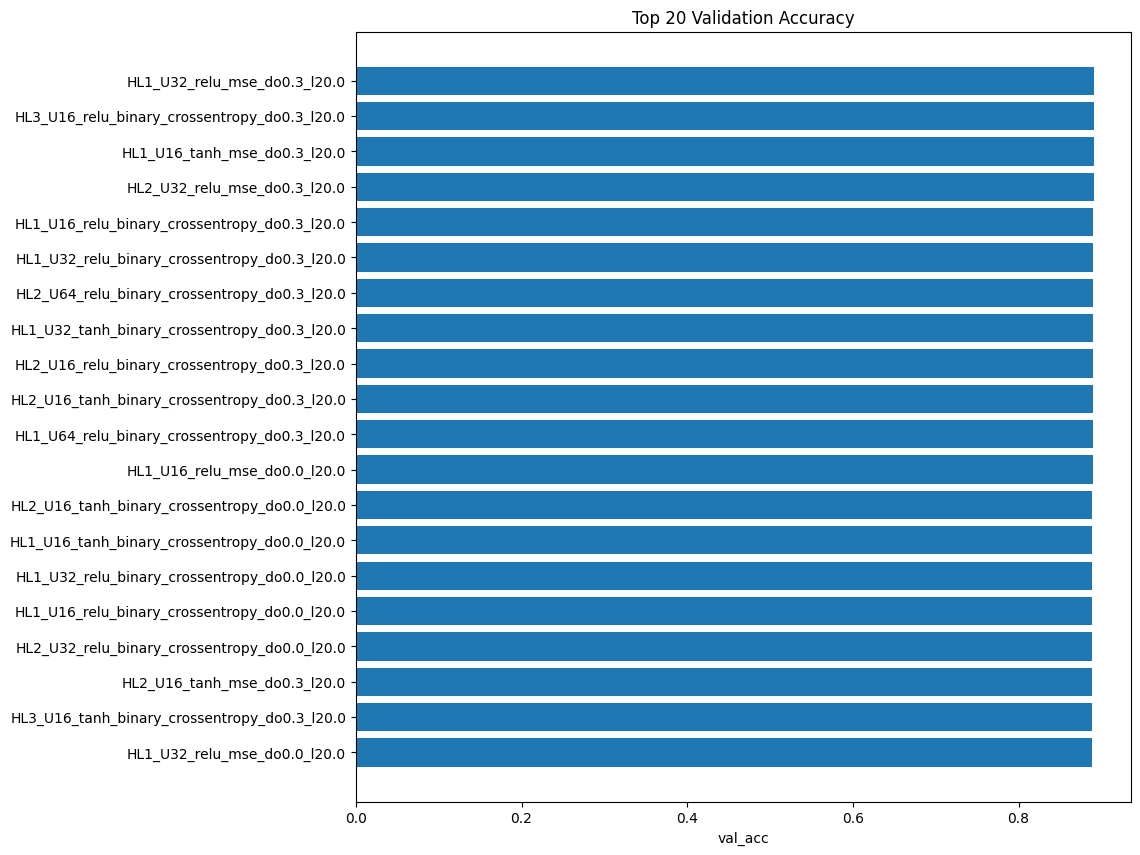

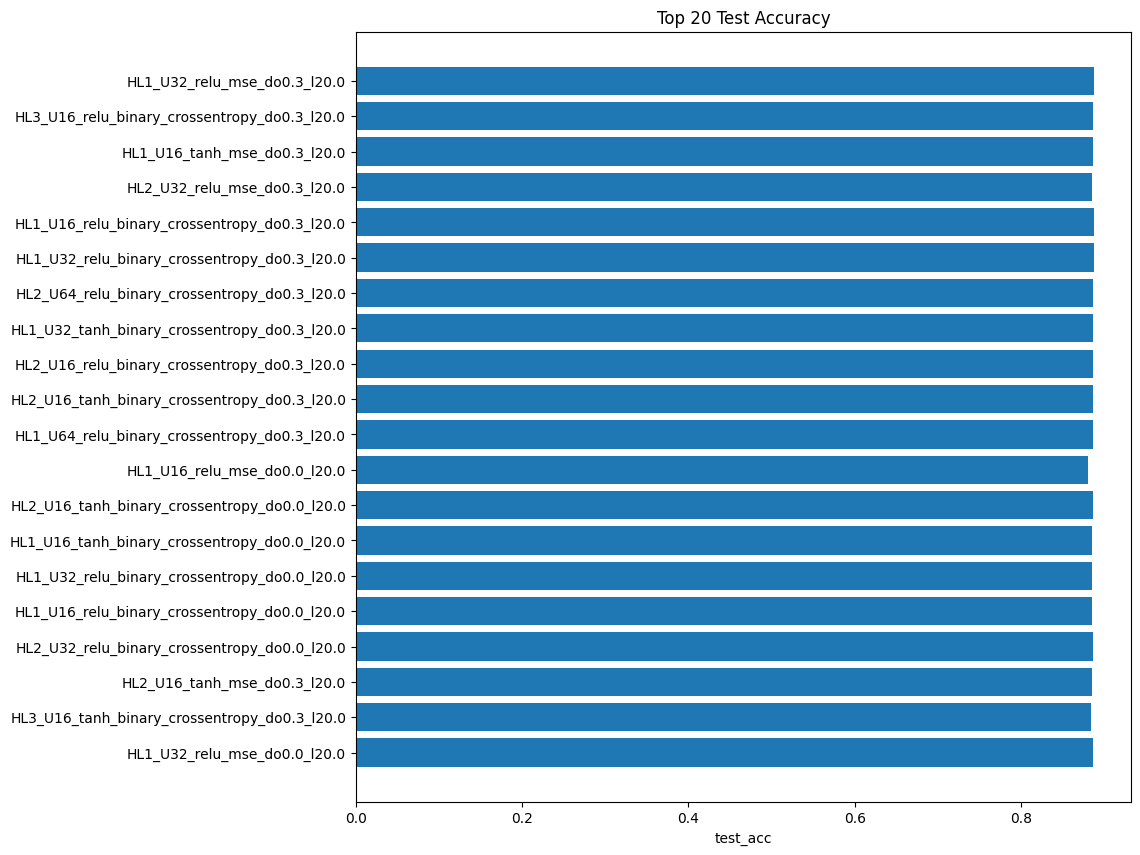

In [24]:
df.to_csv("results_assignment2.csv", index=False)

from IPython.display import display
display(df.head(10))

TOP = min(20, len(df))
plt.figure(figsize=(10, 0.35*TOP + 3))
plt.barh(df['name'].head(TOP), df['val_acc'].head(TOP))
plt.title(f"Top {TOP} Validation Accuracy")
plt.xlabel("val_acc")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 0.35*TOP + 3))
plt.barh(df['name'].head(TOP), df['test_acc'].head(TOP))
plt.title(f"Top {TOP} Test Accuracy")
plt.xlabel("test_acc")
plt.gca().invert_yaxis()
plt.show()


In [25]:
best = df.iloc[0].to_dict()
print("Best configuration:")
for k, v in best.items():
    print(f"- {k}: {v}")
with open("best_config.json", "w") as f:
    json.dump(best, f, indent=2)


Best configuration:
- name: HL1_U32_relu_mse_do0.3_l20.0
- hidden_layers: 1
- units: 32
- activation: relu
- loss: mse
- dropout: 0.3
- l2: 0.0
- val_acc: 0.890999972820282
- val_loss: 0.08380435407161713
- test_acc: 0.8878399729728699
- test_loss: 0.0861949622631073


In [26]:
def avg(col):
    return df.groupby(col)['val_acc'].mean().sort_values(ascending=False).to_frame('mean_val_acc')

print("Avg by hidden_layers:\n", avg('hidden_layers'), "\n")
print("Avg by units:\n", avg('units'), "\n")
print("Avg by activation:\n", avg('activation'), "\n")
print("Avg by loss:\n", avg('loss'), "\n")
print("Avg by dropout:\n", avg('dropout'), "\n")
print("Avg by l2:\n", avg('l2'), "\n")


Avg by hidden_layers:
                mean_val_acc
hidden_layers              
1                  0.888100
2                  0.886558
3                  0.884758 

Avg by units:
        mean_val_acc
units              
16         0.887783
32         0.886867
64         0.884767 

Avg by activation:
             mean_val_acc
activation              
relu            0.887133
tanh            0.885811 

Avg by loss:
                      mean_val_acc
loss                             
binary_crossentropy      0.886850
mse                      0.886094 

Avg by dropout:
          mean_val_acc
dropout              
0.3          0.887567
0.0          0.885378 

Avg by l2:
      mean_val_acc
l2               
0.0      0.886472 

